In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [5]:
# Load dataset
file_path = "ev_charging_patterns_augmented.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found at {file_path}")

df = pd.read_csv(file_path)
df.dropna(inplace=True)



In [6]:
# Time features
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'], errors='coerce')
df['Hour'] = df['Charging Start Time'].dt.hour
df['Weekday'] = df['Charging Start Time'].dt.weekday
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)



In [7]:
# Interaction features
if 'Charging Power (kW)' in df.columns:
    df['Power x Duration'] = df['Charging Power (kW)'] * df['Charging Duration (hours)']
elif 'Charging Rate (kW)' in df.columns:
    df['Power x Duration'] = df['Charging Rate (kW)'] * df['Charging Duration (hours)']
else:
    df['Power x Duration'] = 0

if 'Vehicle Model' in df.columns:
    df['Model x Weekday'] = df['Vehicle Model'].astype(str) + "_" + df['Weekday'].astype(str)
else:
    df['Model x Weekday'] = df['Weekday'].astype(str)



In [8]:
# Lag and rolling features
df['Lag1_Energy'] = df['Energy Consumed (kWh)'].shift(1)
df['Lag2_Energy'] = df['Energy Consumed (kWh)'].shift(2)
df['Lag1_Duration'] = df['Charging Duration (hours)'].shift(1)
df['Rolling_Mean_Energy'] = df['Energy Consumed (kWh)'].rolling(window=3).mean()
df['Rolling_Std_Energy'] = df['Energy Consumed (kWh)'].rolling(window=3).std()
df.fillna(method='bfill', inplace=True)



C:\Users\mugal\AppData\Local\Temp\ipykernel_17592\1935067600.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [9]:
# Define targets
targets = ['Energy Consumed (kWh)', 'Charging Duration (hours)']
drop_cols = ['User ID', 'Charging Start Time'] if 'User ID' in df.columns else ['Charging Start Time']
X = df.drop(targets + drop_cols, axis=1)
y = df[targets]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize input
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalize output
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Reshape for GRU
X_train_gru = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_gru = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build GRU model
def build_gru_model(input_shape):
    inp = Input(shape=input_shape)
    x = GRU(64, return_sequences=False)(inp)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(2)(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(0.0005), loss='mse')
    return model

gru_model = build_gru_model((X_train_gru.shape[1], X_train_gru.shape[2]))
early_stop = EarlyStopping(patience=10, restore_best_weights=True)



In [10]:
print("\n🧠 Training GRU Model for both targets...")
gru_model.fit(X_train_gru, y_train_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

# GRU predictions
gru_train_pred_scaled = gru_model.predict(X_train_gru)
gru_test_pred_scaled = gru_model.predict(X_test_gru)

gru_train_pred = scaler_y.inverse_transform(gru_train_pred_scaled)
gru_test_pred = scaler_y.inverse_transform(gru_test_pred_scaled)

# Merge GRU outputs into XGBoost input
X_train_xgb = np.hstack([X_train_scaled, gru_train_pred])
X_test_xgb = np.hstack([X_test_scaled, gru_test_pred])

# Train XGBoost models
output_names = ['Energy Consumed (kWh)', 'Charging Duration (hours)']
xgb_models = []
y_pred_list = []




🧠 Training GRU Model for both targets...
Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9499 - val_loss: 0.5575
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9499 - val_loss: 0.5575
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4618 - val_loss: 0.1573
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4618 - val_loss: 0.1573
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2222 - val_loss: 0.1124
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2222 - val_loss: 0.1124
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1696 - val_loss: 0.0869
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1696 - val_loss: 0.0869
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1384 - val_loss: 0.0679
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1384 - val_loss: 0.0679
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1151 - val_loss: 0.0558
E

In [11]:
print("\n🚀 Training XGBoost models for both targets...")
for i in range(2):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train_xgb, y_train.iloc[:, i])
    xgb_models.append(model)
    y_pred_list.append(model.predict(X_test_xgb))




🚀 Training XGBoost models for both targets...



📊 Evaluation for: Energy Consumed (kWh)
MAE:  0.6188
RMSE: 1.0113
MAPE: 0.0729
R²:   0.9979


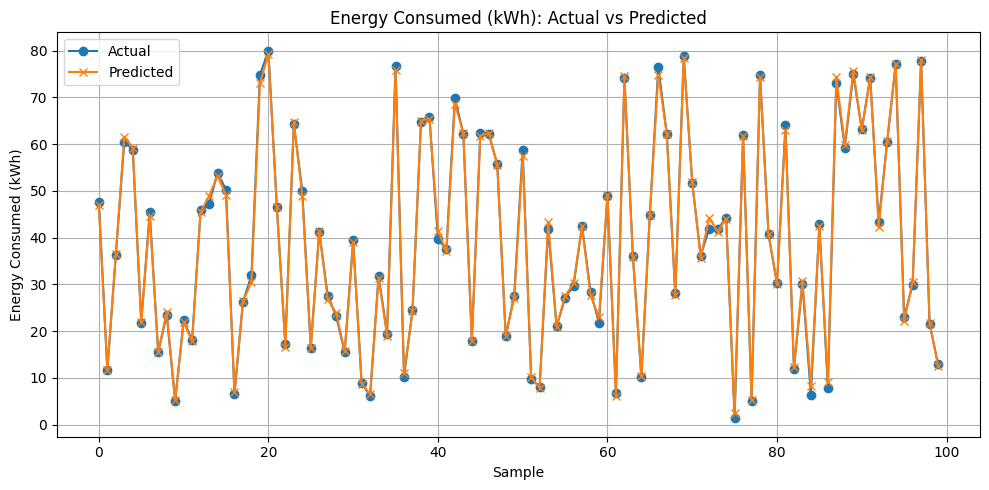


📊 Evaluation for: Charging Duration (hours)
MAE:  0.0236
RMSE: 0.0367
MAPE: 0.0135
R²:   0.9987


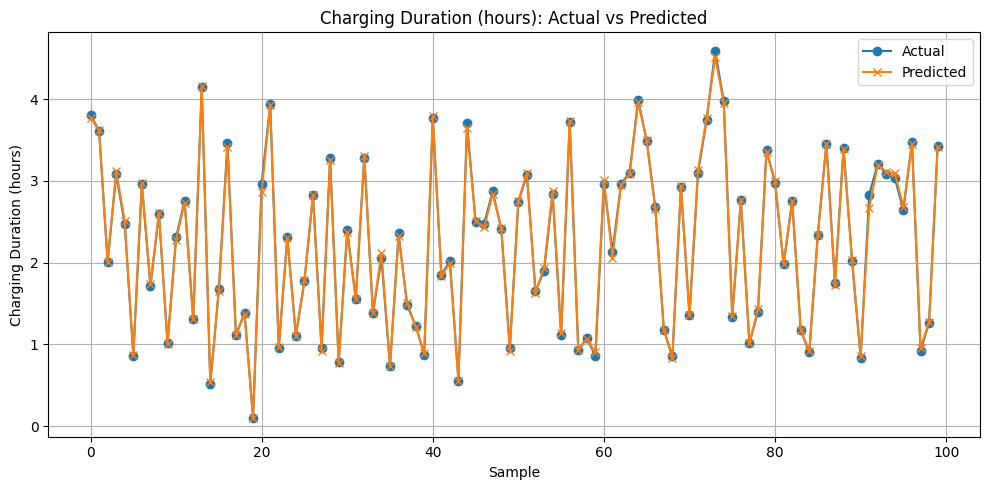

In [12]:
# Evaluate and plot
for i in range(2):
    print(f"\n📊 Evaluation for: {output_names[i]}")
    y_true = y_test.iloc[:, i]
    y_pred = y_pred_list[i]
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_true.values[:100], label='Actual', marker='o')
    plt.plot(y_pred[:100], label='Predicted', marker='x')
    plt.title(f"{output_names[i]}: Actual vs Predicted")
    plt.xlabel("Sample")
    plt.ylabel(output_names[i])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
# Print the feature list used for model input (for API integration)
print('API input feature order:')
print(X.columns.tolist())

API input feature order:


NameError: name 'X' is not defined